In [8]:
import numpy as np
import cv2

import glob
import os
from PIL import Image

import tensorflow as tf

In [14]:
def imshow(img: np.ndarray, in_bgr: bool = True):
    if in_bgr:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(img)
    display(image)

In [15]:
PATH_TO_INPUT = "./data/training_input"
PATH_TO_TRUTH = "./data/training_ground-truth"
filenames = glob.glob("*", root_dir=PATH_TO_INPUT)

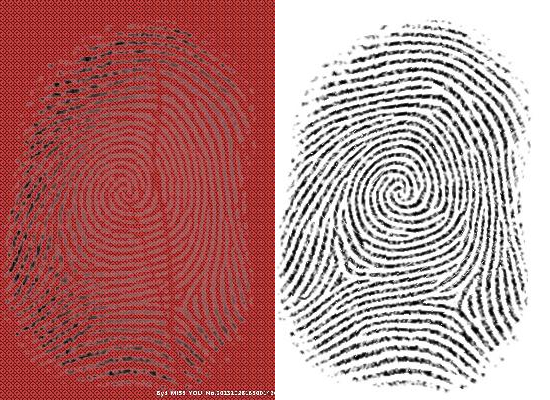

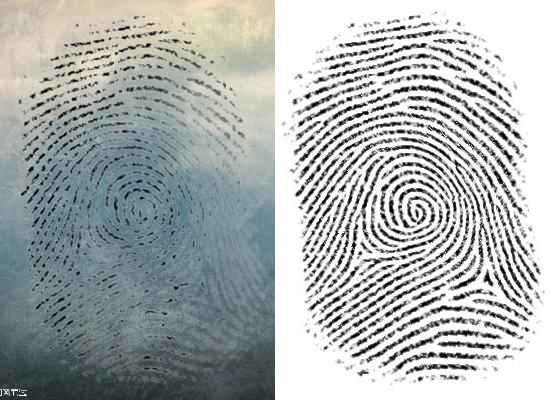

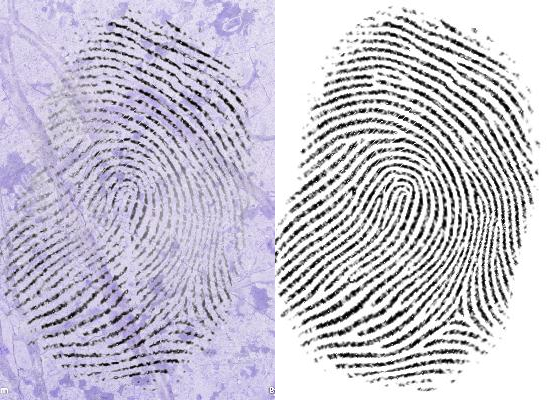

In [16]:
random_filenames = np.random.choice(filenames, 3)
for fname in random_filenames:
    img_input = cv2.imread(os.path.join(PATH_TO_INPUT, fname), cv2.IMREAD_UNCHANGED)
    img_truth = cv2.imread(os.path.join(PATH_TO_TRUTH, fname), cv2.IMREAD_UNCHANGED)
    img_truth = cv2.cvtColor(img_truth, cv2.COLOR_GRAY2BGR)
    imshow(np.concatenate([img_input, img_truth], axis=1))

In [30]:
from data_loading import FingerprintDatasetFactory

In [31]:
ds_factory = FingerprintDatasetFactory()
train_ds = ds_factory.create_dataset(PATH_TO_INPUT, PATH_TO_TRUTH, batch_size=4, seed=42)

Found 75600 files belonging to 1 classes.
Found 75600 files belonging to 1 classes.
